In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load the merged and cleaned calendar data
calendar_data = pd.read_csv(r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Merged_Data\paris_merged_calendar.csv")

# Quick check of the data
print("Dataset shape:", calendar_data.shape)
print("\nColumns:", calendar_data.columns.tolist())
print("\nFirst few rows:")
print(calendar_data.head())
print("\nBasic statistics:")
print(calendar_data.describe())

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Load the listings data
listings_data = pd.read_csv(r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Data_Mor\paris\2024-09-06\listings.csv")

# Quick check of the data
print("Dataset shape:", listings_data.shape)
print("\nColumns:", listings_data.columns.tolist())
print("\nFirst few rows:")
print(listings_data.head())
print("\nBasic statistics:")
print(listings_data.describe())

Dataset shape: (95461, 75)

Columns: ['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availabili

In [2]:
# Select relevant columns from listings DataFrame
listings_cleaned = listings_data[['id', 'neighbourhood_cleansed', 'latitude', 'longitude']]

# Verify the structures
print("Listings shape:", listings_cleaned.shape)
print("\nListings columns:", listings_cleaned.columns.tolist())

Listings shape: (95461, 4)

Listings columns: ['id', 'neighbourhood_cleansed', 'latitude', 'longitude']


In [3]:
def load_and_prepare_data(calendar_path, listings_path, n_listings=500):
    """Load and prepare the data with basic cleaning and sampling."""
    # Load listings first to get the sample
    listings_df = pd.read_csv(listings_path)
    
    # Randomly sample n_listings
    sampled_listings = listings_df['id'].sample(n=n_listings, random_state=42)
    
    # Clean and prepare listings data
    listings_cleaned = listings_df[listings_df['id'].isin(sampled_listings)][
        ['id', 'neighbourhood_cleansed', 'latitude', 'longitude']
    ]
    listings_cleaned = listings_cleaned.rename(columns={'id': 'listing_id'})
    
    # Load calendar data
    calendar_df = pd.read_csv(calendar_path)
    
    # Filter calendar data for sampled listings
    calendar_df = calendar_df[calendar_df['listing_id'].isin(sampled_listings)]
    
    # Merge calendar with listings data
    df = pd.merge(calendar_df, listings_cleaned, on='listing_id', how='left')
    df['date'] = pd.to_datetime(df['date'])
    
    print(f"Total listings in sample: {len(df['listing_id'].unique())}")
    print(f"Total records in sample: {len(df)}")
    
    return df

In [4]:
# Call the function with your file paths
calendar_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Merged_Data\paris_merged_calendar.csv"
listings_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\Data_Mor\paris\2024-09-06\listings.csv"

# Load and prepare the data
df = load_and_prepare_data(calendar_path, listings_path, n_listings=500)

Total listings in sample: 500
Total records in sample: 332673


In [5]:
print(df)

                 listing_id       date   price neighbourhood_cleansed  \
0                     25450 2024-03-18   320.0               Entrepôt   
1                     25450 2024-03-19   320.0               Entrepôt   
2                     25450 2024-03-20   320.0               Entrepôt   
3                     25450 2024-03-21   320.0               Entrepôt   
4                     25450 2024-03-22   320.0               Entrepôt   
...                     ...        ...     ...                    ...   
332668  1235588205340106663 2025-09-06  6000.0                  Passy   
332669  1235588205340106663 2025-09-07  6000.0                  Passy   
332670  1235588205340106663 2025-09-08  6000.0                  Passy   
332671  1235588205340106663 2025-09-09  6000.0                  Passy   
332672  1235588205340106663 2025-09-10  6000.0                  Passy   

         latitude  longitude  
0       48.870070   2.364420  
1       48.870070   2.364420  
2       48.870070   2.364420  

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from datetime import datetime

class ParisDataPreparation:
    def __init__(self):
        self.scaler = StandardScaler()        
    
    def clean_price(self, df, price_column='price'):
        """Clean price values"""
        # Remove currency symbols and convert to float
        df[price_column] = df[price_column].replace('[\$,€,£]', '', regex=True)
        df[price_column] = df[price_column].astype(str).str.replace(',', '')
        df[price_column] = pd.to_numeric(df[price_column], errors='coerce')
        return df
    
    def handle_missing_values(self, df):
        """Handle missing values for key columns"""
        # For numerical columns
        numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
        for col in numeric_columns:
            df[col] = df[col].fillna(df[col].median())
        
        # For categorical columns
        categorical_columns = df.select_dtypes(include=['object']).columns
        for col in categorical_columns:
            df[col] = df[col].fillna(df[col].mode()[0])
            
        return df
    
    def clean_coordinates(self, df):
        """Clean and validate coordinates for Paris"""
        # Paris coordinate bounds
        PARIS_LAT_MIN, PARIS_LAT_MAX = 48.8, 48.9
        PARIS_LON_MIN, PARIS_LON_MAX = 2.2, 2.5
        
        # Filter invalid coordinates
        mask = (
            (df['latitude'] >= PARIS_LAT_MIN) & 
            (df['latitude'] <= PARIS_LAT_MAX) &
            (df['longitude'] >= PARIS_LON_MIN) & 
            (df['longitude'] <= PARIS_LON_MAX)
        )
        return df[mask]
    
    def handle_outliers(self, df, column='price', method='iqr'):
        """Remove outliers using IQR method"""
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    def prepare_date_features(self, df):
        """Create date-related features"""
        df['date'] = pd.to_datetime(df['date'])
        df['day_of_week'] = df['date'].dt.dayofweek
        df['month'] = df['date'].dt.month
        df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
        
        # Paris high season (summer months and December)
        df['is_high_season'] = df['month'].isin([6, 7, 8, 12]).astype(int)
        
        return df
    
    def prepare_basic_features(self, df):
        """Prepare basic features for baseline model"""
        basic_features = [
            'listing_id',
            'date',
            'price',
            'latitude',
            'longitude',
            'neighbourhood_cleansed' 
        ]
        return df[basic_features]
    
    def prepare_advanced_features(self, df):
        """Add advanced features"""
        df = df.copy()
        
        # Calculate distance to center (Chatelet as Paris center)
        PARIS_CENTER_LAT = 48.8589
        PARIS_CENTER_LON = 2.3469
        df['distance_to_center'] = np.sqrt(
            (df['latitude'] - PARIS_CENTER_LAT)**2 + 
            (df['longitude'] - PARIS_CENTER_LON)**2
        )
        
        # Add temporal features
        df = self.prepare_date_features(df)
        
        # Add neighborhood statistics
        neighborhood_stats = df.groupby('neighbourhood_cleansed')['price'].agg(
            ['mean', 'std']
        ).reset_index()
        df = df.merge(
            neighborhood_stats, 
            on='neighbourhood_cleansed', 
            how='left',
            suffixes=('', '_neighborhood_avg')
        )
        
        return df
    
    def scale_features(self, df, columns_to_scale):
        """Scale numerical features"""
        df[columns_to_scale] = self.scaler.fit_transform(df[columns_to_scale])
        return df
    
    def prepare_data(self, df, advanced=False):
        """Main preparation pipeline"""
        # Make a copy to avoid modifying original
        df = df.copy()
        
        # Basic cleaning
        df = self.clean_price(df)
        df = self.handle_missing_values(df)
        df = self.handle_outliers(df)
        df = self.prepare_date_features(df)
        
        if not advanced:
            # Prepare basic features for baseline
            df = self.prepare_basic_features(df)
        else:
            # Prepare advanced features
            df = self.prepare_advanced_features(df)
        
        # Scale numerical features (except listing_id and date)
        numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
        numerical_columns = numerical_columns[~numerical_columns.isin(['listing_id'])]
        df = self.scale_features(df, numerical_columns)
        
        return df


<>:13: SyntaxWarning: invalid escape sequence '\$'
<>:13: SyntaxWarning: invalid escape sequence '\$'
C:\Users\matth\AppData\Local\Temp\ipykernel_22536\2843440462.py:13: SyntaxWarning: invalid escape sequence '\$'
  df[price_column] = df[price_column].replace('[\$,€,£]', '', regex=True)


In [7]:
# First, import required libraries and create the preprocessor
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Initialize the preprocessor
preprocessor = ParisDataPreparation()

# Let's first look at the data before preparation
print("Original DataFrame shape:", df.shape)
print("\nOriginal DataFrame columns:", df.columns.tolist())
print("\nMissing values before preparation:\n", df.isnull().sum())

# Now apply the preparation for both baseline and advanced
baseline_data = preprocessor.prepare_data(df, advanced=False)
advanced_data = preprocessor.prepare_data(df, advanced=True)

# Check the results
print("\nBaseline DataFrame shape:", baseline_data.shape)
print("Advanced DataFrame shape:", advanced_data.shape)

# Look at the first few rows of each
print("\nBaseline features:\n", baseline_data.columns.tolist())
print("\nAdvanced features:\n", advanced_data.columns.tolist())

Original DataFrame shape: (332673, 6)

Original DataFrame columns: ['listing_id', 'date', 'price', 'neighbourhood_cleansed', 'latitude', 'longitude']

Missing values before preparation:
 listing_id                0
date                      0
price                     0
neighbourhood_cleansed    0
latitude                  0
longitude                 0
dtype: int64

Baseline DataFrame shape: (302251, 6)
Advanced DataFrame shape: (302251, 13)

Baseline features:
 ['listing_id', 'date', 'price', 'latitude', 'longitude', 'neighbourhood_cleansed']

Advanced features:
 ['listing_id', 'date', 'price', 'neighbourhood_cleansed', 'latitude', 'longitude', 'day_of_week', 'month', 'is_weekend', 'is_high_season', 'distance_to_center', 'mean', 'std']



Linear Regression Results:
Train RMSE: 596.65
Test RMSE: 713.17
Train R²: 0.0503
Test R²: 0.0531

Moving Average (7-day) Results:
Test RMSE: 0.00
Test R²: 1.0000

Moving Average (30-day) Results:
Test RMSE: 0.00
Test R²: 1.0000


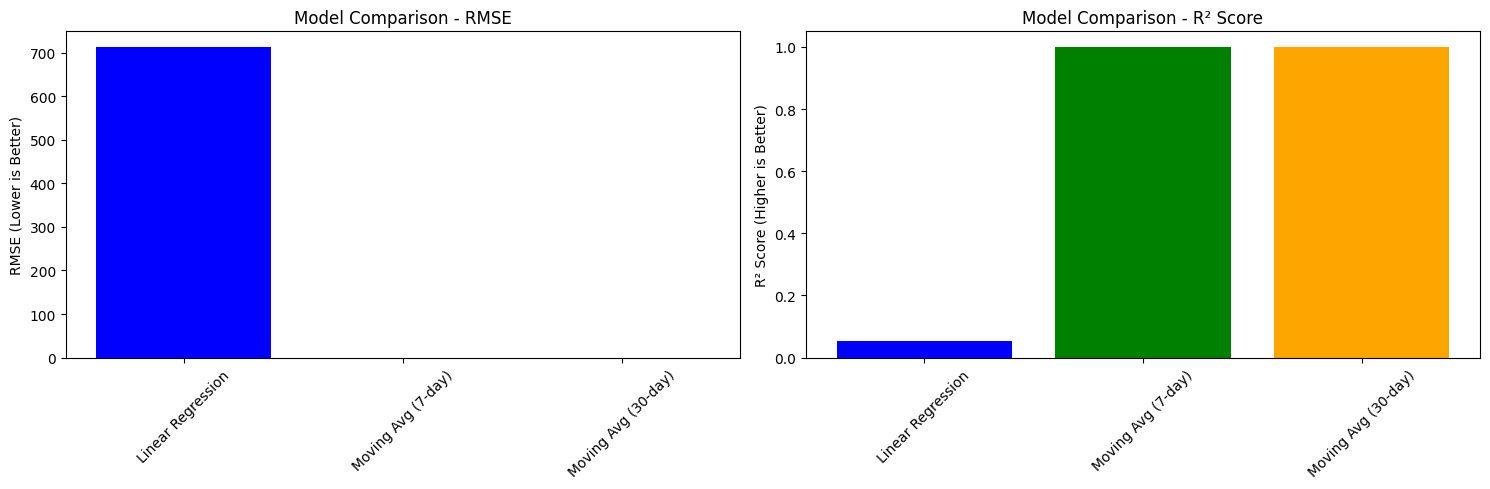

In [8]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

class BaselineModels:
    def __init__(self):
        self.linear_model = LinearRegression()
        self.onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # Fixed parameter name
        
    def prepare_features(self, df):
        """Prepare features for linear regression"""
        df = df.copy()
        
        # Extract month from date
        df['date'] = pd.to_datetime(df['date'])
        df['month'] = df['date'].dt.month
        
        # One-hot encode neighbourhood
        neighborhood_encoded = self.onehot.fit_transform(df[['neighbourhood_cleansed']])
        
        # Create feature matrix
        X = np.column_stack([
            df[['latitude', 'longitude', 'month']],
            neighborhood_encoded
        ])
        
        return X, df['price']
    
    def train_test_split_temporal(self, df, test_size=0.2):
        """Split data temporally - last test_size portion as test set"""
        df = df.sort_values('date')
        split_idx = int(len(df) * (1 - test_size))
        train = df.iloc[:split_idx]
        test = df.iloc[split_idx:]
        return train, test
    
    def linear_regression_baseline(self, df, test_size=0.2):
        """Simple linear regression baseline with temporal split"""
        # Split data temporally
        train_df, test_df = self.train_test_split_temporal(df, test_size)
        
        # Prepare features
        X_train, y_train = self.prepare_features(train_df)
        X_test, y_test = self.prepare_features(test_df)
        
        # Fit model
        self.linear_model.fit(X_train, y_train)
        
        # Make predictions
        train_pred = self.linear_model.predict(X_train)
        test_pred = self.linear_model.predict(X_test)
        
        # Calculate metrics
        results = {
            'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
            'test_rmse': np.sqrt(mean_squared_error(y_test, test_pred)),
            'train_r2': r2_score(y_train, train_pred),
            'test_r2': r2_score(y_test, test_pred)
        }
        
        return results
    
    def moving_average_baseline(self, df, window_size=7):
        """Moving average baseline using only past data"""
        df = df.copy()
        df['date'] = pd.to_datetime(df['date'])
        
        # Sort by listing_id and date
        df = df.sort_values(['listing_id', 'date'])
        
        # Calculate moving average using shift to avoid future data leakage
        df['ma_prediction'] = df.groupby('listing_id')['price'].transform(
            lambda x: x.shift(1).rolling(window=window_size, min_periods=1).mean()
        )
        
        # Split data temporally
        train_df, test_df = self.train_test_split_temporal(df)
        
        # Calculate metrics for test set only
        mask = ~test_df['ma_prediction'].isna()  # Remove NaN predictions
        
        test_rmse = np.sqrt(mean_squared_error(
            test_df.loc[mask, 'price'],
            test_df.loc[mask, 'ma_prediction']
        ))
        
        test_r2 = r2_score(
            test_df.loc[mask, 'price'],
            test_df.loc[mask, 'ma_prediction']
        )
        
        results = {
            'test_rmse': test_rmse,
            'test_r2': test_r2
        }
        
        return results

def plot_model_comparison(lr_results, ma7_results, ma30_results):
    """Plot comparison of model results"""
    import matplotlib.pyplot as plt
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # RMSE comparison
    models = ['Linear Regression', 'Moving Avg (7-day)', 'Moving Avg (30-day)']
    rmse_values = [lr_results['test_rmse'], ma7_results['test_rmse'], ma30_results['test_rmse']]
    ax1.bar(models, rmse_values, color=['blue', 'green', 'orange'])
    ax1.set_title('Model Comparison - RMSE')
    ax1.set_ylabel('RMSE (Lower is Better)')
    ax1.tick_params(axis='x', rotation=45)
    
    # R² comparison
    r2_values = [lr_results['test_r2'], ma7_results['test_r2'], ma30_results['test_r2']]
    ax2.bar(models, r2_values, color=['blue', 'green', 'orange'])
    ax2.set_title('Model Comparison - R² Score')
    ax2.set_ylabel('R² Score (Higher is Better)')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig

# Usage
baselines = BaselineModels()

# Linear regression baseline
lr_results = baselines.linear_regression_baseline(df)
print("\nLinear Regression Results:")
print(f"Train RMSE: {lr_results['train_rmse']:.2f}")
print(f"Test RMSE: {lr_results['test_rmse']:.2f}")
print(f"Train R²: {lr_results['train_r2']:.4f}")
print(f"Test R²: {lr_results['test_r2']:.4f}")

# Moving average baselines
ma7_results = baselines.moving_average_baseline(df, window_size=7)
ma30_results = baselines.moving_average_baseline(df, window_size=30)

print("\nMoving Average (7-day) Results:")
print(f"Test RMSE: {ma7_results['test_rmse']:.2f}")
print(f"Test R²: {ma7_results['test_r2']:.4f}")

print("\nMoving Average (30-day) Results:")
print(f"Test RMSE: {ma30_results['test_rmse']:.2f}")
print(f"Test R²: {ma30_results['test_r2']:.4f}")

# Plot results
fig = plot_model_comparison(lr_results, ma7_results, ma30_results)
plt.show()

Starting model evaluation...
Running Linear Regression...

Linear Regression Results:
Train RMSE: 596.65
Test RMSE: 713.17
Train R²: 0.0503
Test R²: 0.0531

Running Random Forest...

Random Forest Results:
Train RMSE: 214.18
Test RMSE: 226.30
Train R²: 0.8776
Test R²: 0.9047


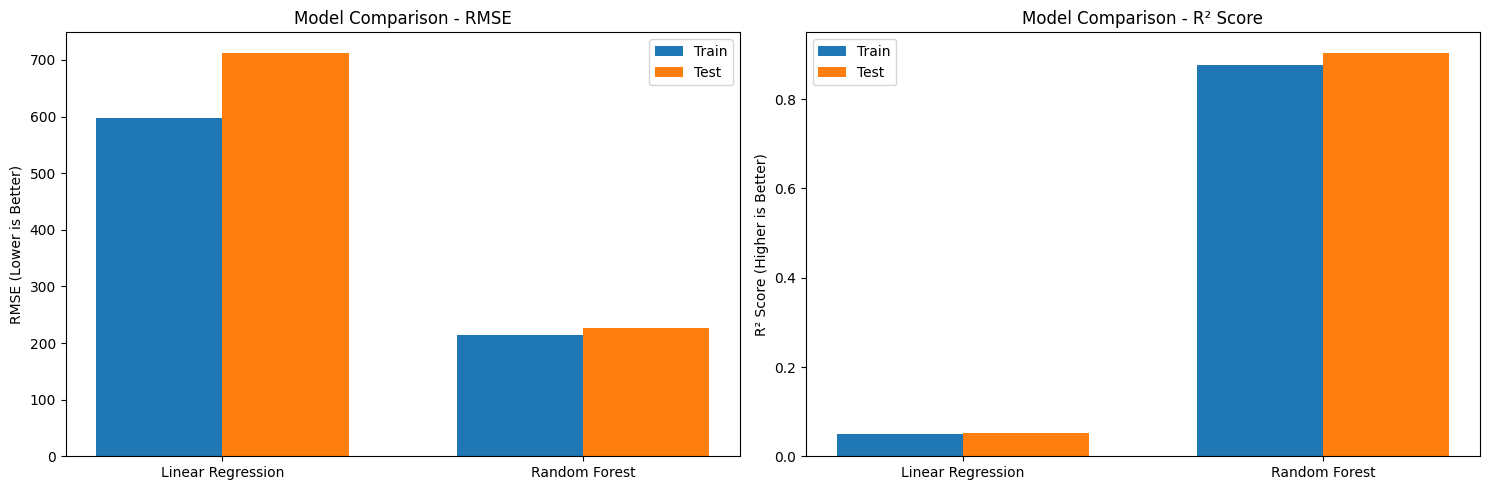

In [9]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler

class BaselineModels:
    def __init__(self):
        self.linear_model = LinearRegression()
        self.rf_model = RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            min_samples_split=10,
            random_state=42
        )
        self.onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.scaler = StandardScaler()
        
    def prepare_features(self, df, train=True):
        """Prepare features for models"""
        df = df.copy()
        
        # Extract temporal features
        df['date'] = pd.to_datetime(df['date'])
        df['month'] = df['date'].dt.month
        df['day_of_week'] = df['date'].dt.dayofweek
        df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
        
        # Prepare numerical features
        numerical_features = ['latitude', 'longitude', 'month', 'day_of_week']
        
        if train:
            # Fit and transform on training data
            numerical_scaled = self.scaler.fit_transform(df[numerical_features])
            neighborhood_encoded = self.onehot.fit_transform(df[['neighbourhood_cleansed']])
        else:
            # Only transform on test data
            numerical_scaled = self.scaler.transform(df[numerical_features])
            neighborhood_encoded = self.onehot.transform(df[['neighbourhood_cleansed']])
        
        # Create feature matrix
        X = np.column_stack([numerical_scaled, neighborhood_encoded])
        
        return X, df['price']
    
    def train_test_split_temporal(self, df, test_size=0.2):
        """Split data temporally - last test_size portion as test set"""
        df = df.sort_values('date')
        split_idx = int(len(df) * (1 - test_size))
        train = df.iloc[:split_idx]
        test = df.iloc[split_idx:]
        return train, test
    
    def linear_regression_baseline(self, df, test_size=0.2):
        """Linear regression baseline"""
        # Split data temporally
        train_df, test_df = self.train_test_split_temporal(df, test_size)
        
        # Prepare features
        X_train, y_train = self.prepare_features(train_df, train=True)
        X_test, y_test = self.prepare_features(test_df, train=False)
        
        # Fit model
        self.linear_model.fit(X_train, y_train)
        
        # Make predictions
        train_pred = self.linear_model.predict(X_train)
        test_pred = self.linear_model.predict(X_test)
        
        # Calculate metrics
        results = {
            'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
            'test_rmse': np.sqrt(mean_squared_error(y_test, test_pred)),
            'train_r2': r2_score(y_train, train_pred),
            'test_r2': r2_score(y_test, test_pred)
        }
        
        return results
    
    def random_forest_baseline(self, df, test_size=0.2):
        """Random Forest baseline"""
        # Split data temporally
        train_df, test_df = self.train_test_split_temporal(df, test_size)
        
        # Prepare features
        X_train, y_train = self.prepare_features(train_df, train=True)
        X_test, y_test = self.prepare_features(test_df, train=False)
        
        # Fit model
        self.rf_model.fit(X_train, y_train)
        
        # Make predictions
        train_pred = self.rf_model.predict(X_train)
        test_pred = self.rf_model.predict(X_test)
        
        # Calculate metrics
        results = {
            'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
            'test_rmse': np.sqrt(mean_squared_error(y_test, test_pred)),
            'train_r2': r2_score(y_train, train_pred),
            'test_r2': r2_score(y_test, test_pred)
        }
        
        return results

def plot_model_comparison(lr_results, rf_results):
    """Plot comparison of model results"""
    import matplotlib.pyplot as plt
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # RMSE comparison
    models = ['Linear Regression', 'Random Forest']
    train_rmse = [lr_results['train_rmse'], rf_results['train_rmse']]
    test_rmse = [lr_results['test_rmse'], rf_results['test_rmse']]
    
    x = np.arange(len(models))
    width = 0.35
    
    ax1.bar(x - width/2, train_rmse, width, label='Train')
    ax1.bar(x + width/2, test_rmse, width, label='Test')
    ax1.set_title('Model Comparison - RMSE')
    ax1.set_ylabel('RMSE (Lower is Better)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models)
    ax1.legend()
    
    # R² comparison
    train_r2 = [lr_results['train_r2'], rf_results['train_r2']]
    test_r2 = [lr_results['test_r2'], rf_results['test_r2']]
    
    ax2.bar(x - width/2, train_r2, width, label='Train')
    ax2.bar(x + width/2, test_r2, width, label='Test')
    ax2.set_title('Model Comparison - R² Score')
    ax2.set_ylabel('R² Score (Higher is Better)')
    ax2.set_xticks(x)
    ax2.set_xticklabels(models)
    ax2.legend()
    
    plt.tight_layout()
    return fig

# Usage
print("Starting model evaluation...")
baselines = BaselineModels()

# Linear regression baseline
print("Running Linear Regression...")
lr_results = baselines.linear_regression_baseline(df)
print("\nLinear Regression Results:")
print(f"Train RMSE: {lr_results['train_rmse']:.2f}")
print(f"Test RMSE: {lr_results['test_rmse']:.2f}")
print(f"Train R²: {lr_results['train_r2']:.4f}")
print(f"Test R²: {lr_results['test_r2']:.4f}")

# Random Forest baseline
print("\nRunning Random Forest...")
rf_results = baselines.random_forest_baseline(df)
print("\nRandom Forest Results:")
print(f"Train RMSE: {rf_results['train_rmse']:.2f}")
print(f"Test RMSE: {rf_results['test_rmse']:.2f}")
print(f"Train R²: {rf_results['train_r2']:.4f}")
print(f"Test R²: {rf_results['test_r2']:.4f}")

# Plot results
fig = plot_model_comparison(lr_results, rf_results)
plt.show()


Linear Regression Results:
Overall RMSE: 713.18
Monthly Error Stability: 1.99
Spatial Error Stability: 233.18

Random Forest Results:
Overall RMSE: 208.05
Monthly Error Stability: 12.13
Spatial Error Stability: 35.12


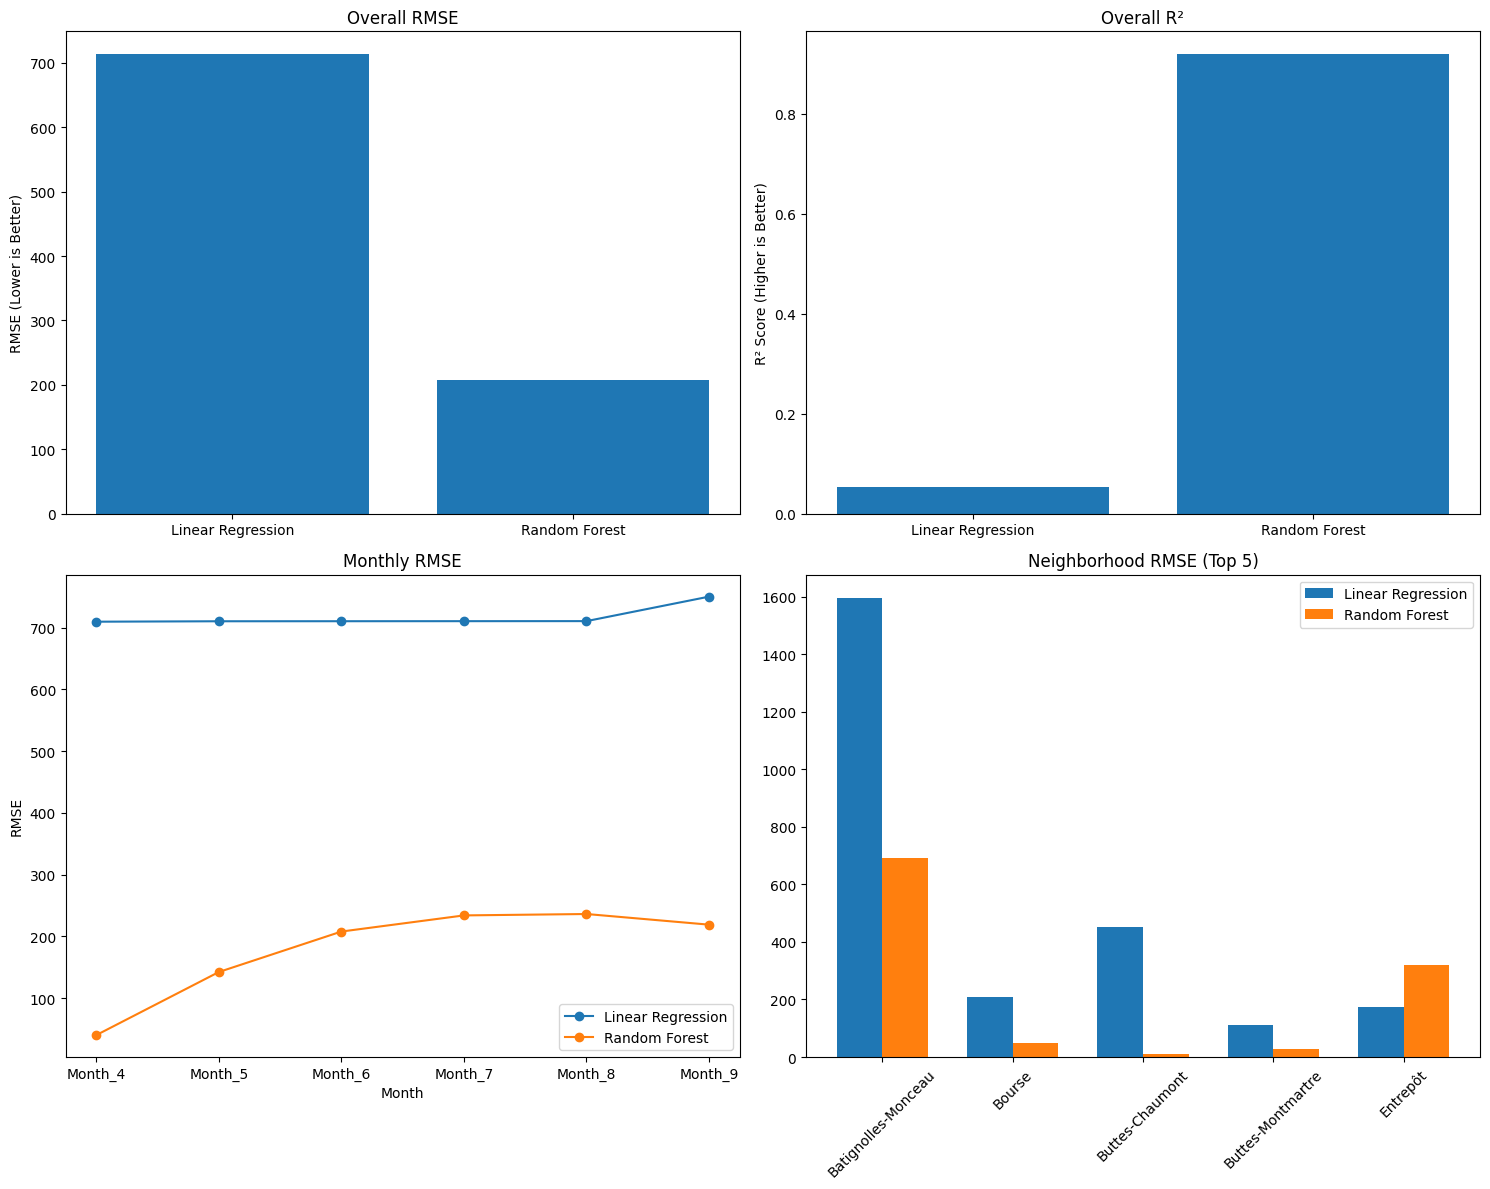

In [10]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler

class SpatioTemporalEvaluation:
    def __init__(self):
        self.linear_model = LinearRegression()
        self.rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
        self.onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        self.scaler = StandardScaler()
        
    def prepare_features(self, df, train=True):
        """Prepare features for models"""
        df = df.copy()
        df['date'] = pd.to_datetime(df['date'])
        df['month'] = df['date'].dt.month
        
        numerical_features = ['latitude', 'longitude', 'month']
        
        if train:
            numerical_scaled = self.scaler.fit_transform(df[numerical_features])
            neighborhood_encoded = self.onehot.fit_transform(df[['neighbourhood_cleansed']])
        else:
            numerical_scaled = self.scaler.transform(df[numerical_features])
            neighborhood_encoded = self.onehot.transform(df[['neighbourhood_cleansed']])
        
        X = np.column_stack([numerical_scaled, neighborhood_encoded])
        return X, df['price']
    
    def evaluate_temporal_performance(self, y_true, y_pred, dates):
        """Evaluate model performance across different time periods"""
        dates = pd.to_datetime(dates)
        temporal_results = {}
        
        # Monthly performance
        for month in sorted(dates.dt.month.unique()):
            mask = dates.dt.month == month
            if sum(mask) > 0:  # Only if we have data for this month
                rmse = np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))
                r2 = r2_score(y_true[mask], y_pred[mask])
                temporal_results[f'Month_{month}'] = {'rmse': rmse, 'r2': r2}
        
        # Calculate month-to-month stability
        monthly_errors = pd.Series(index=dates.dt.month.unique())
        for month in dates.dt.month.unique():
            mask = dates.dt.month == month
            monthly_errors[month] = np.mean(np.abs(y_true[mask] - y_pred[mask]))
        
        temporal_results['monthly_error_std'] = monthly_errors.std()
        
        return temporal_results
    
    def evaluate_spatial_performance(self, y_true, y_pred, neighborhoods):
        """Evaluate model performance across different neighborhoods"""
        spatial_results = {}
        
        # Neighborhood-wise performance
        for neighborhood in sorted(neighborhoods.unique()):
            mask = neighborhoods == neighborhood
            if sum(mask) > 0:  # Only if we have data for this neighborhood
                rmse = np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))
                r2 = r2_score(y_true[mask], y_pred[mask])
                spatial_results[neighborhood] = {'rmse': rmse, 'r2': r2}
        
        # Calculate spatial autocorrelation of errors
        neighborhood_errors = pd.Series(index=neighborhoods.unique())
        for neighborhood in neighborhoods.unique():
            mask = neighborhoods == neighborhood
            neighborhood_errors[neighborhood] = np.mean(np.abs(y_true[mask] - y_pred[mask]))
        
        spatial_results['neighborhood_error_std'] = neighborhood_errors.std()
        
        return spatial_results
    
    def evaluate_model(self, model, X_train, X_test, y_train, y_test, test_df):
        """Evaluate a model with both temporal and spatial metrics"""
        # Fit model and make predictions
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        # Overall metrics
        overall_results = {
            'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
            'test_rmse': np.sqrt(mean_squared_error(y_test, test_pred)),
            'train_r2': r2_score(y_train, train_pred),
            'test_r2': r2_score(y_test, test_pred)
        }
        
        # Temporal evaluation
        temporal_results = self.evaluate_temporal_performance(
            y_test, test_pred, test_df['date']
        )
        
        # Spatial evaluation
        spatial_results = self.evaluate_spatial_performance(
            y_test, test_pred, test_df['neighbourhood_cleansed']
        )
        
        return {
            'overall': overall_results,
            'temporal': temporal_results,
            'spatial': spatial_results
        }
    
    def run_evaluation(self, df):
        """Run complete evaluation pipeline"""
        # Temporal train-test split
        df = df.sort_values('date')
        split_idx = int(len(df) * 0.8)
        train_df = df.iloc[:split_idx]
        test_df = df.iloc[split_idx:]
        
        # Prepare features
        X_train, y_train = self.prepare_features(train_df, train=True)
        X_test, y_test = self.prepare_features(test_df, train=False)
        
        # Evaluate Linear Regression
        lr_results = self.evaluate_model(
            self.linear_model, X_train, X_test, y_train, y_test, test_df
        )
        
        # Evaluate Random Forest
        rf_results = self.evaluate_model(
            self.rf_model, X_train, X_test, y_train, y_test, test_df
        )
        
        return lr_results, rf_results

def plot_evaluation_results(lr_results, rf_results):
    """Plot comprehensive evaluation results"""
    import matplotlib.pyplot as plt
    
    # Create figure with multiple subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Overall Performance
    models = ['Linear Regression', 'Random Forest']
    metrics = ['test_rmse', 'test_r2']
    values = [
        [lr_results['overall']['test_rmse'], rf_results['overall']['test_rmse']],
        [lr_results['overall']['test_r2'], rf_results['overall']['test_r2']]
    ]
    
    ax1.bar(models, values[0])
    ax1.set_title('Overall RMSE')
    ax1.set_ylabel('RMSE (Lower is Better)')
    
    ax2.bar(models, values[1])
    ax2.set_title('Overall R²')
    ax2.set_ylabel('R² Score (Higher is Better)')
    
    # Temporal Stability
    months = sorted([k for k in lr_results['temporal'].keys() if k.startswith('Month')])
    lr_temporal = [lr_results['temporal'][m]['rmse'] for m in months]
    rf_temporal = [rf_results['temporal'][m]['rmse'] for m in months]
    
    ax3.plot(months, lr_temporal, label='Linear Regression', marker='o')
    ax3.plot(months, rf_temporal, label='Random Forest', marker='o')
    ax3.set_title('Monthly RMSE')
    ax3.set_xlabel('Month')
    ax3.set_ylabel('RMSE')
    ax3.legend()
    
    # Spatial Performance
    neighborhoods = sorted([k for k in lr_results['spatial'].keys() 
                          if k != 'neighborhood_error_std'])[:5]  # Top 5 neighborhoods
    lr_spatial = [lr_results['spatial'][n]['rmse'] for n in neighborhoods]
    rf_spatial = [rf_results['spatial'][n]['rmse'] for n in neighborhoods]
    
    x = np.arange(len(neighborhoods))
    width = 0.35
    
    ax4.bar(x - width/2, lr_spatial, width, label='Linear Regression')
    ax4.bar(x + width/2, rf_spatial, width, label='Random Forest')
    ax4.set_title('Neighborhood RMSE (Top 5)')
    ax4.set_xticks(x)
    ax4.set_xticklabels(neighborhoods, rotation=45)
    ax4.legend()
    
    plt.tight_layout()
    return fig

# Usage
evaluator = SpatioTemporalEvaluation()
lr_results, rf_results = evaluator.run_evaluation(df)

# Print detailed results
print("\nLinear Regression Results:")
print(f"Overall RMSE: {lr_results['overall']['test_rmse']:.2f}")
print(f"Monthly Error Stability: {lr_results['temporal']['monthly_error_std']:.2f}")
print(f"Spatial Error Stability: {lr_results['spatial']['neighborhood_error_std']:.2f}")

print("\nRandom Forest Results:")
print(f"Overall RMSE: {rf_results['overall']['test_rmse']:.2f}")
print(f"Monthly Error Stability: {rf_results['temporal']['monthly_error_std']:.2f}")
print(f"Spatial Error Stability: {rf_results['spatial']['neighborhood_error_std']:.2f}")

# Plot results
fig = plot_evaluation_results(lr_results, rf_results)
plt.show()